In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import physo
from physo.task import benchmark
from physo.learn import monitoring

/Users/youriran/software/PhySO/physo/physym/program.py:20: UserWarning: Can not import display packages.
  warnings.warn("Can not import display packages.")


Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  10
Recommended config {'parallel_mode': False, 'n_cpus': 10}
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo f

/Users/youriran/software/PhySO/physo/physym/execute.py:190: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
/Users/youriran/software/PhySO/physo/physym/reward.py:224: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
p = 10**np.linspace(0, 8, 100)
def langmuir(b, q):
    bp = b*p
    return q * b * p / (1 + b * p)

X = torch.Tensor(p).reshape(1, -1)
y = torch.Tensor(langmuir(1e-4, 2.0))
const1 = torch.Tensor([1.])


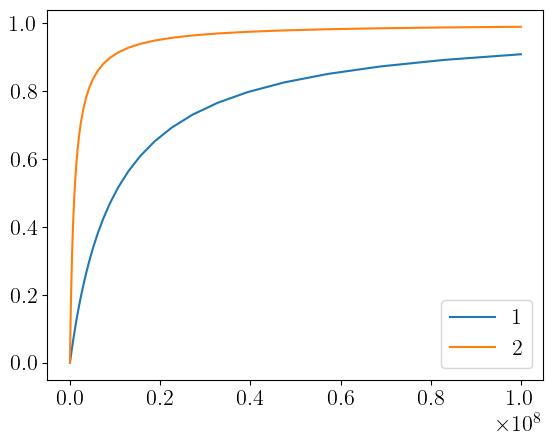

In [3]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
b1, q1 = 1e-7, 1.0
b2, q2 = 1e-6, 1.0
ax.plot(p, langmuir(b1, q1), label="1")
ax.plot(p, langmuir(b2, q2), label="2")
ax.legend()

In [4]:
# [length, mass, time]
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "neg"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"p" : 0         ,},
                "input_var_units"      : {"p" : [-2, 0, 1] ,},
                "input_var_complexity" : {"p" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"b", "qsat"},
                "free_constants_init_val"   : {"b" : 1., "qsat" : 1.},
                "free_constants_units"      : {"b" : [2, 0, -1] , "qsat" : [0, 1, 0]},
                "free_constants_complexity" : {"b" : 1., "qsat" : 1.},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, 1, 0],
                  "superparent_name"  : "q",
                }

reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, 
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                 "parallel_mode" : True,
                 "n_cpus"        : None,
                }

DEVICE = "cpu"
BATCH_SIZE = int(1e3)
MAX_LENGTH = 16
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e2),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-6,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 2, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 3, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                #("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

cell_config = {
    "hidden_size" : 32,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 10,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  10
Recommended config {'parallel_mode': False, 'n_cpus': 10}


/Users/youriran/software/PhySO/physo/physym/execute.py:190: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
/Users/youriran/software/PhySO/physo/physym/reward.py:224: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


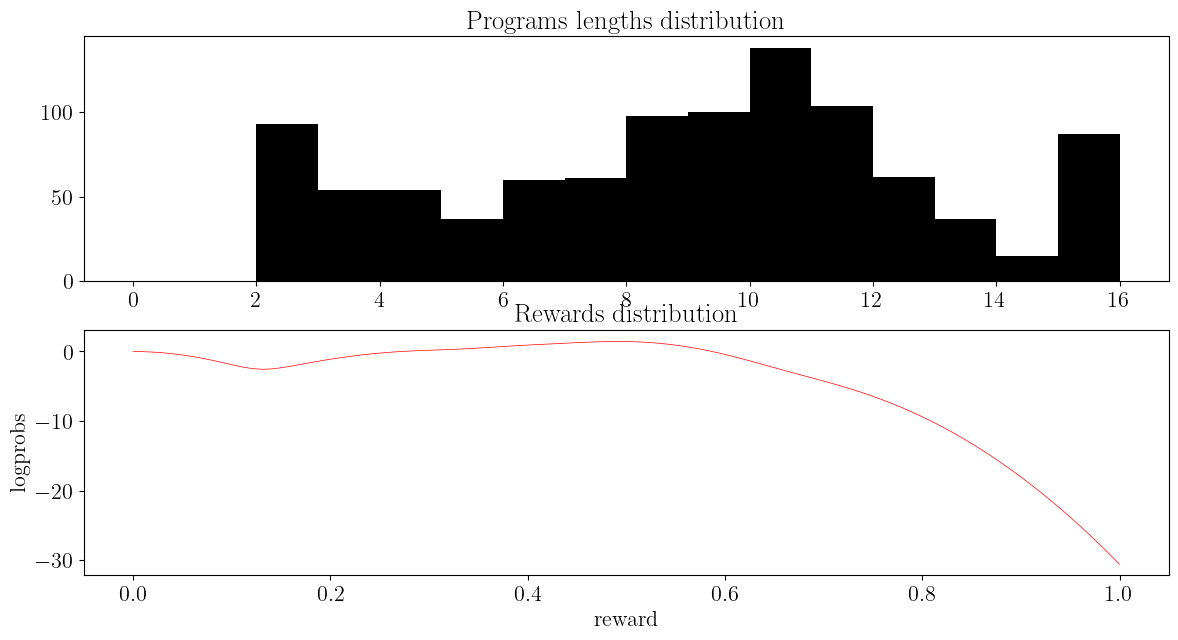

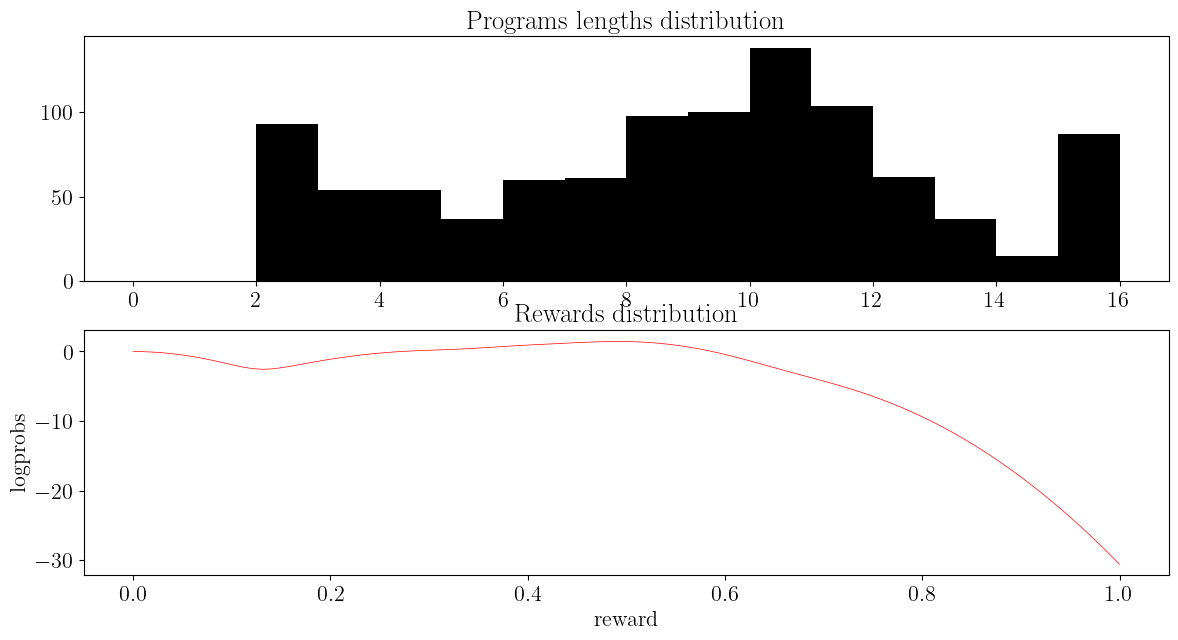

In [5]:
benchmark.dummy_epoch(X, y, run_config)

In [6]:
rewards, candidates = physo.fit(X, y, run_config, stop_reward=0.999, stop_after_n_epochs=5)

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00000 ===========
-> Time 6.28 s

Overall best  at R=0.680345
-> Raw expression : 
b + b
─────
    1
b + ─
    p

Best of epoch at R=0.680345
-> Raw expression : 
b + b
─────
    1
b + ─
    p


=========== Epoch 00001 ===========
-> Time 13.04 s

Overall best  at R=0.680345
-> Raw expression : 
b + b
─────
    1
b + ─
    p

Best of epoch at R=0.630202
-> Raw expression : 
 b           1
─── - qsat + ─
⎛1⎞          1
⎜─⎟           
⎝p⎠           


=========== Epoch 00002 ===========
-> Time 14.06 s

Overall best  at R=0.680345
-> Raw expression : 
b + b
─────
    1
b + ─
    p

Best of epoch at R=0.662317
-> Raw expression : 
-b⋅qsat 
────────
  ⎛1⎞   
  ⎜─⎟   
  ⎝p⎠   


=========== Epoch 00003 ===========
-> Time 13.27 s

Overall best  at R=0.680345
-> Raw expression : 
b + b
─────
    1
b + ─
    p

Best of epoch at R=0.639430
-> Raw expression : 
           1            
────────────────────────
         

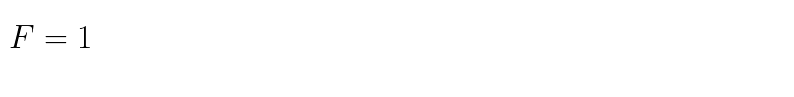

b = 1.000000
qsat = 1.000000


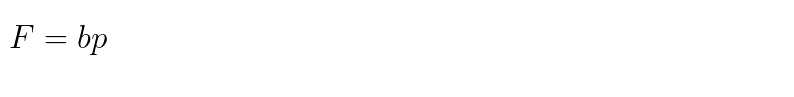

b = 0.000187
qsat = 1.000000


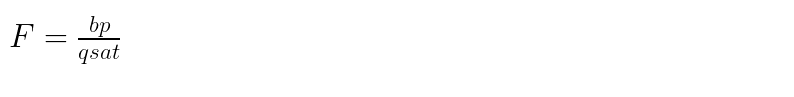

b = 0.000292
qsat = 1.607076


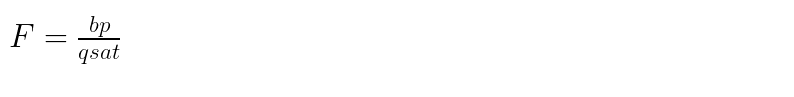

b = 0.000117
qsat = 0.626849


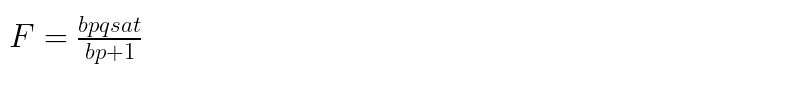

b = 0.000514
qsat = 1.658574


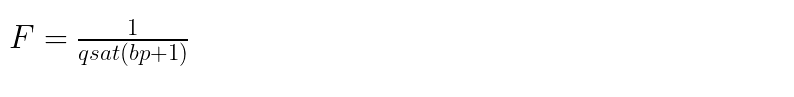

b = 4091.777537
qsat = -0.407046


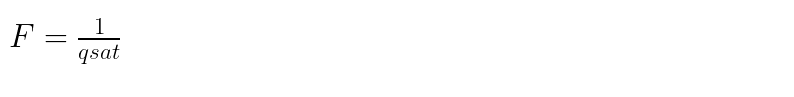

b = 1.842206
qsat = 5.955622


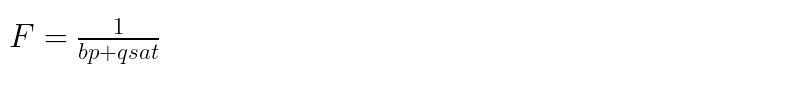

b = 4999.974781
qsat = 0.500000


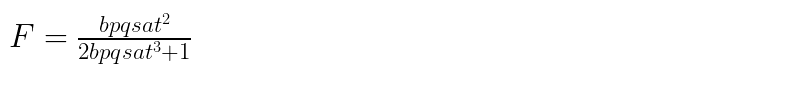

b = 0.003200
qsat = 0.250001


In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_const_values.detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))